In [62]:
import uproot as u
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from df_utils import *

In [63]:
run = "run3"
dm_type = "fermion"
mass = "0.05"
target_pot = 1.
signal_pot = {}

bkg_upper_limit = 1.14 


if(dm_type == "fermion"):
    signal_pot = { "0.01":4.49230189e+20, "0.02":3.24986846e+21, "0.03":1.44413783e+22, 
                  "0.04":5.51306150e+22, "0.05":1.74805153e+23, "0.06":5.79056950e+23,
                  "0.07":1.48783150e+24, "0.08":4.41322940e+24, 
                  "0.09":9.92424735e+24, "0.10":2.27414738e+25}

else: 
    signal_pot = { "0.01":8.70545727e+21, "0.02": 9.48797710e+22, "0.03":4.86277630e+23, 
                  "0.04":1.94231827e+24, "0.05":8.19564834e+24, "0.06":2.06542023e+25,
                  "0.07":5.83217654e+25, "0.08":1.54999742e+26, 
                  "0.09":2.94329651e+26, "0.10":5.04481005e+26}


scalings_run1 = { "nu":1./2.34e21, "dirt":0.75/1.6e21, "beamoff": 1.56*0.98}
scalings_run3 = { "nu":1./1.993661e21, "dirt":0.35/1.020e21, "beamoff": 2.909}

scalings = {}

if(run == "run1"):
    target_pot = 2.0e20
    scalings = scalings_run1
    pot_label = r'                    $2\times10^{20}$ POT'
else:
    target_pot = 5.0e20
    scalings = scalings_run3
    pot_label = r'                    $5\times10^{20}$ POT'

signal_scaling = target_pot/signal_pot[mass]
nu_scaling = target_pot*scalings["nu"]
dirt_scaling = target_pot*scalings["dirt"]
offbeam_scaling = scalings["beamoff"]

In [64]:
base_dir = "E:/data/" + run + "_samples/" 
plots_dir = "E:/result/bdt/"

df_signal = pd.read_csv(base_dir + "df_trident" + "_" + mass + "_score_test.csv")
df_nu = pd.read_csv(base_dir + run + "_nu_overlay_bdt_score.csv")
df_dirt = pd.read_csv(base_dir + run + "_dirt_bdt_score.csv")
df_offbeam = pd.read_csv(base_dir + run + "_offbeam_score.csv")


MC_weight_branch(df_nu)
MC_weight_branch(df_dirt)


In [65]:
def logit_transform(score):
    return np.log(score/(1-score))

def filter_df(df):
    df = df[df['bdt_score'] >= 0.5]
    return df


def GetStatsUncert(df_a, variable,  weight_array, pot_weight):
    (counts_df, bins_df) = np.histogram(df_a[variable], bins = binning, weights=np.square(weight_array*pot_weight))
    counts_df[counts_df == 0.] = bkg_upper_limit*np.square(pot_weight)
    return counts_df 
                       

Maximum of signal score: 5.109977737428518
Binning:  [0.0, 0.5677753041587242, 1.1355506083174485, 1.7033259124761728, 2.271101216634897, 2.838876520793621, 3.4066518249523456, 5.109977737428518]
[0.15731802 0.18592129 0.28889309 0.53488126 0.75226615 1.0783435
 4.01589992]
Showing results for: run3
Number of dark tridents M_A=0.05 :7.013523222624908
Number of neutrinos: nan
Number of dirt: 9.35978029411765
Number of beam-off: 23.272


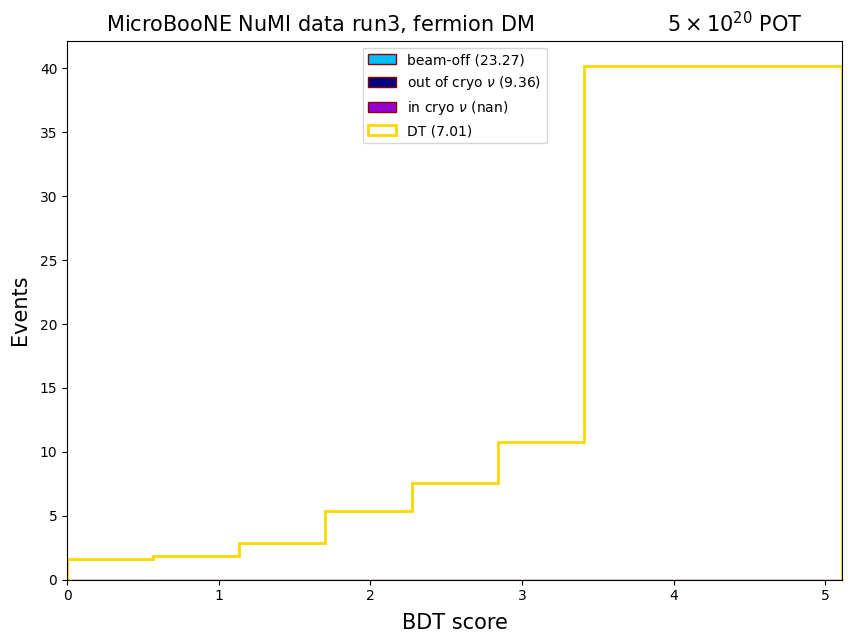

In [66]:
df_signal = filter_df(df_signal)
df_nu = filter_df(df_nu)
df_dirt = filter_df(df_dirt)
df_offbeam = filter_df(df_offbeam)


df_signal['bdt_score'] = logit_transform(df_signal['bdt_score'])
df_nu['bdt_score'] = logit_transform(df_nu['bdt_score'])
df_dirt['bdt_score'] = logit_transform(df_dirt['bdt_score'])
df_offbeam['bdt_score'] = logit_transform(df_offbeam['bdt_score'])


print("Maximum of signal score:", np.max(df_signal['bdt_score']))

n_bins = 9
binning = np.linspace(0., np.max(df_signal['bdt_score']) ,n_bins+1)
binning = np.delete(binning, [len(binning) - 3, len(binning) - 2])
print("Binning: ", binning.tolist())
variable = 'bdt_score'
bdt_range = (0., binning[-1])




(counts_signal, bins_signal) = np.histogram(df_signal[variable], bins = binning)
(counts_nu, bins_nu) = np.histogram(df_nu[variable], bins = binning, weights = df_nu['weight'])
(counts_dirt, bins_dirt) = np.histogram(df_dirt[variable], bins = binning, weights = df_dirt['weight'])
(counts_offbeam, bins_offbeam) = np.histogram(df_offbeam[variable], bins = binning)

print(counts_signal*signal_scaling)


#(counts_signal, bins_signal) = np.histogram(logit_transform(df_signal['bdt_score']), bins = n_bins)
#(counts_nu, bins_nu) = np.histogram(logit_transform(df_nu['bdt_score']), bins = n_bins)
#(counts_dirt, bins_dirt) = np.histogram(logit_transform(df_dirt['bdt_score']), bins = n_bins)
#(counts_offbeam, bins_offbeam) = np.histogram(logit_transform(df_offbeam['bdt_score']), bins = n_bins)

# This adds 68% upper limit on top of those bins with zero events 
counts_dirt[counts_dirt == 0.] = bkg_upper_limit
counts_offbeam[counts_offbeam == 0.] = bkg_upper_limit


print("Showing results for: " + run)
print("Number of dark tridents M_A="+str(mass)+" :" + str(np.sum(counts_signal)*signal_scaling))
print("Number of neutrinos: " + str(np.sum(counts_nu)*nu_scaling))
print("Number of dirt: " + str(np.sum(counts_dirt)*dirt_scaling))
print("Number of beam-off: " + str(np.sum(counts_offbeam)*offbeam_scaling))

# Set plot specs with patches!!!

dt_legend = r'DT ({:.2f})'.format(np.sum(counts_signal)*signal_scaling)
nu_legend = r'in cryo $\nu$ ({:.2f})'.format(np.sum(counts_nu)*nu_scaling)
dirt_legend = r'out of cryo $\nu$ ({:.2f})'.format(np.sum(counts_dirt)*dirt_scaling)
beamoff_legend = r'beam-off ({:.2f})'.format(np.sum(counts_offbeam)*offbeam_scaling)

stacked_colors = ["darkviolet","navy","deepskyblue"]
stacked_legend = [nu_legend, dirt_legend, beamoff_legend]
stacked_bins = [bins_nu[:-1], bins_dirt[:-1], bins_offbeam[:-1]]
stacked_list = [counts_nu*nu_scaling, counts_dirt*dirt_scaling, counts_offbeam*offbeam_scaling ]
plt.figure(figsize=(10,7))
plt.hist(stacked_bins, bins = bins_nu, weights = stacked_list, histtype='stepfilled',stacked=True, color = stacked_colors, edgecolor="darkred", label = stacked_legend)
plt.hist(bins_signal[:-1], bins = bins_signal,weights=counts_signal*signal_scaling*10, histtype='step',label=dt_legend ,fill=False, edgecolor='gold', linewidth=2)
plt.legend(loc="upper center",fontsize=10)
plt.title(r'MicroBooNE NuMI data' + ' ' + run + ', ' + dm_type + ' DM' + pot_label ,fontsize=15)
plt.xlim(0.,5.)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel(r'BDT score',fontsize=15,labelpad=7)
plt.ylabel("Events",fontsize=15, labelpad=7)
plt.xlim(bdt_range)
plt.savefig(plots_dir + dm_type + "_BDT_logits_" + run + "_dist.png")

C:\Users\steve\AppData\Local\Temp\ipykernel_7280\23016155.py:29: RuntimeWarning: invalid value encountered in divide
  ppfx_error = np.sqrt(ppfx_uncert)/counts_bkg
C:\Users\steve\AppData\Local\Temp\ipykernel_7280\23016155.py:30: RuntimeWarning: invalid value encountered in divide
  genie_error = np.sqrt(genie_uncert)/counts_bkg
C:\Users\steve\AppData\Local\Temp\ipykernel_7280\23016155.py:31: RuntimeWarning: invalid value encountered in divide
  reint_error = np.sqrt(reint_uncert)/counts_bkg
C:\Users\steve\AppData\Local\Temp\ipykernel_7280\23016155.py:32: RuntimeWarning: invalid value encountered in divide
  det_error = np.sqrt(det_uncert)/counts_bkg
C:\Users\steve\AppData\Local\Temp\ipykernel_7280\23016155.py:33: RuntimeWarning: invalid value encountered in divide
  syst_error = (syst_uncert)/counts_bkg
C:\Users\steve\AppData\Local\Temp\ipykernel_7280\23016155.py:34: RuntimeWarning: invalid value encountered in divide
  stats_error = np.sqrt(stats_nu + stats_dirt + stats_offbeam)/count

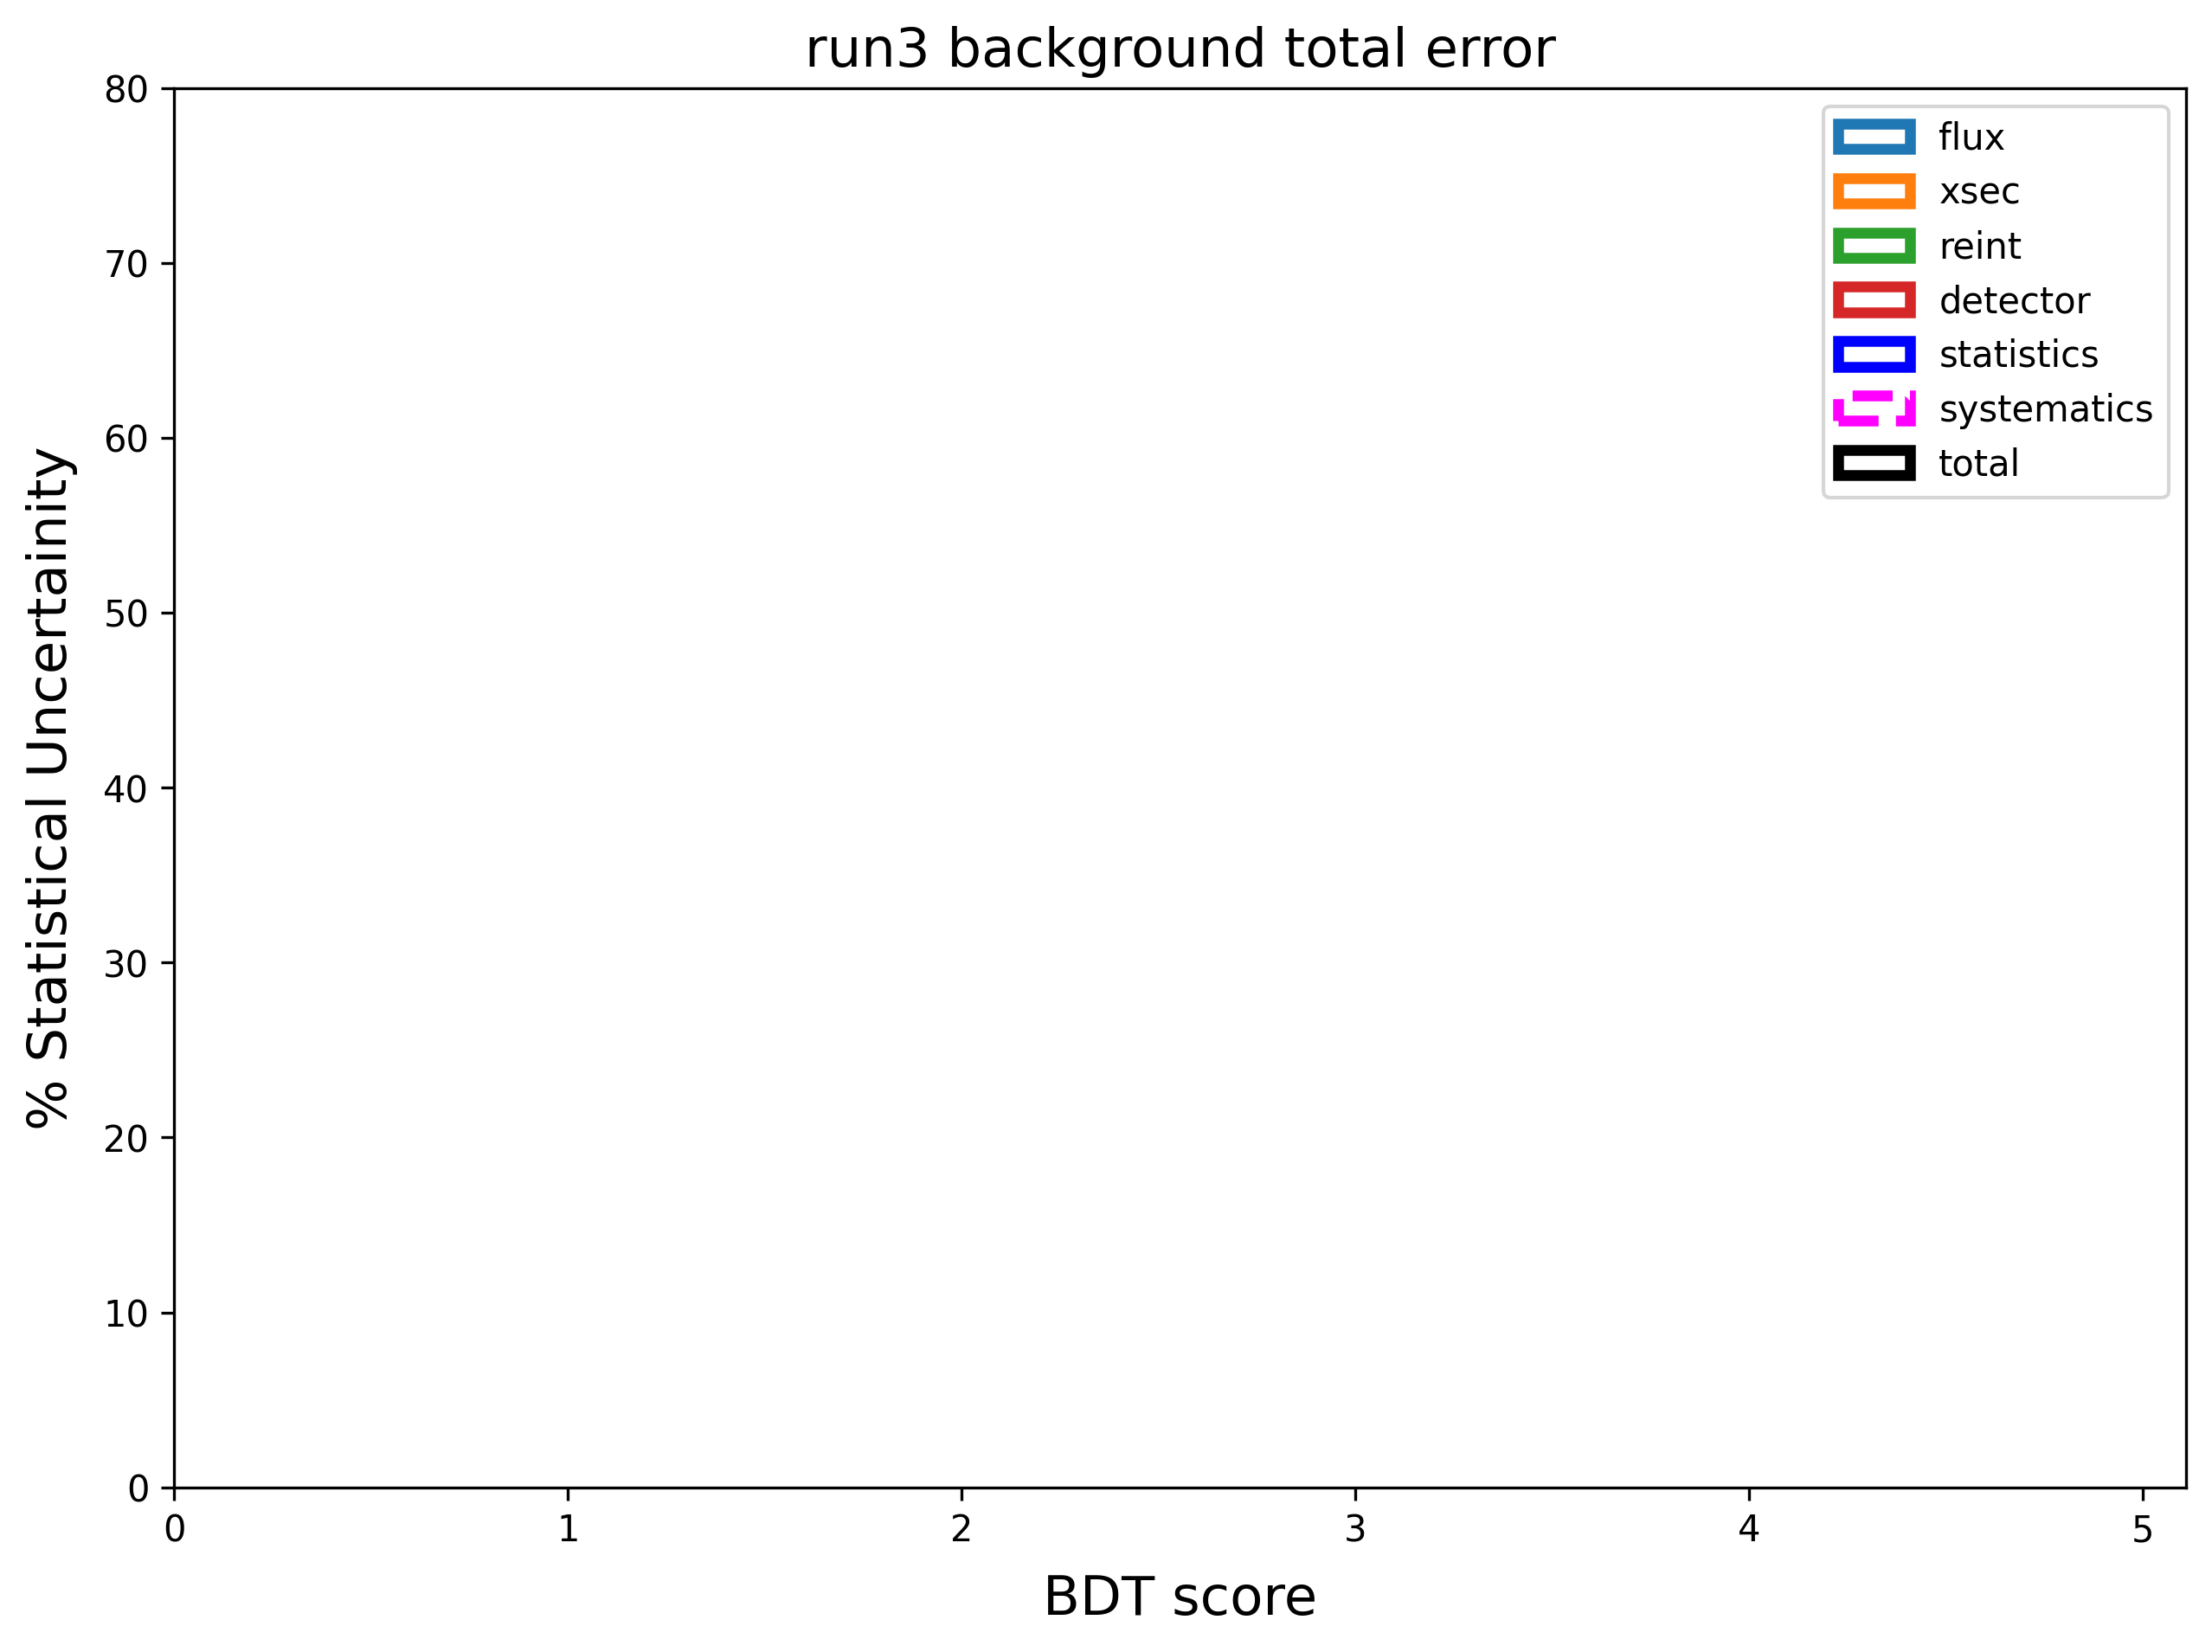

In [67]:
# Setting the MC expectation for empty bins to be the 68% upper limit
counts_bkg = counts_nu*nu_scaling + counts_dirt*dirt_scaling+ counts_offbeam*offbeam_scaling
counts_overlay = counts_nu*nu_scaling 

stats_nu = GetStatsUncert(df_nu,'bdt_score', df_nu['weight'], nu_scaling)
stats_dirt = GetStatsUncert(df_dirt,'bdt_score', df_dirt['weight'], dirt_scaling )
stats_offbeam = GetStatsUncert(df_offbeam,'bdt_score', np.ones(len(df_offbeam))*offbeam_scaling, offbeam_scaling)


if(run=='run1'):
    ppfx_uncert = counts_overlay*0.2
    genie_uncert = counts_overlay*0.15
    reint_uncert = counts_overlay*0.03
    det_uncert = counts_overlay*0.5
else:
    ppfx_uncert = counts_overlay*0.13
    genie_uncert = counts_overlay*0.10
    reint_uncert = counts_overlay*0.025
    det_uncert = counts_overlay*0.5





syst_uncert = np.sqrt(np.square(ppfx_uncert) + np.square(genie_uncert) + np.square(reint_uncert) + np.square(det_uncert))
overlay_uncert = np.sqrt(stats_nu + np.square(syst_uncert) )
total_uncert = np.sqrt( np.square(overlay_uncert) + stats_dirt + stats_offbeam )

ppfx_error = np.sqrt(ppfx_uncert)/counts_bkg
genie_error = np.sqrt(genie_uncert)/counts_bkg
reint_error = np.sqrt(reint_uncert)/counts_bkg
det_error = np.sqrt(det_uncert)/counts_bkg
syst_error = (syst_uncert)/counts_bkg
stats_error = np.sqrt(stats_nu + stats_dirt + stats_offbeam)/counts_bkg
total_error = np.sqrt(np.square(overlay_uncert) + stats_dirt + stats_offbeam)/counts_bkg


plt.figure(figsize=(10,7),dpi=300)
plt.hist(bins_signal[:-1], bins = bins_signal,weights=ppfx_error*100, histtype="step",lw=3,linestyle="-",label="flux")
plt.hist(bins_signal[:-1], bins = bins_signal,weights=genie_error*100, histtype="step",lw=3,linestyle="-",label="xsec")
plt.hist(bins_signal[:-1], bins = bins_signal,weights=reint_error*100, histtype="step",lw=3,linestyle="-",label="reint")
plt.hist(bins_signal[:-1], bins = bins_signal,weights=det_error*100, histtype="step",lw=3,linestyle="-",label="detector")
plt.hist(bins_signal[:-1], bins = bins_signal,weights=stats_error*100, color = "blue", histtype="step",lw=3,linestyle="-",label="statistics")
plt.hist(bins_signal[:-1], bins = bins_signal,weights=syst_error*100, color = "magenta", histtype="step",lw=3,linestyle="--",label="systematics")
plt.hist(bins_signal[:-1], bins = bins_signal,weights=total_error*100, color = "black", histtype="step",lw=3,linestyle="-",label="total")
plt.title(run + " background total error",fontsize=15)
plt.ylabel("% Statistical Uncertainity",fontsize=15,labelpad=7)
plt.xlabel("BDT score",fontsize=15,labelpad=7)
plt.xlim(bdt_range)
plt.ylim(0.,80.)
plt.legend()
bkg_file = u.recreate(base_dir + "background_hist_" + run + "_bdt.root")
plt.savefig(plots_dir + dm_type + "_BDT_logits_" + run + "_errors.png")
bkg_file["background_hist"] = (counts_bkg, bins_nu)
bkg_file["background_uncertainty"] = (total_uncert, bins_nu)